In [4]:
import pandas as pd

# Load your CSV file
file_path = "D:/iot/university_mental_health_iot_dataset.csv"  # adjust path if needed
df = pd.read_csv(file_path)

# Now you can run the rest:
summary_stats = df.describe()
missing_values = df.isnull().sum()

print(summary_stats)
print(missing_values)


       location_id  temperature_celsius  humidity_percent  air_quality_index  \
count  1000.000000          1000.000000       1000.000000        1000.000000   
mean    103.004000            24.208457         60.189320          85.446000   
std       1.433192             3.012801          9.747296          37.970526   
min     101.000000            15.235949         29.804878          20.000000   
25%     102.000000            22.183079         53.726462          51.000000   
50%     103.000000            24.168562         60.048989          86.000000   
75%     104.000000            26.125555         66.726456         119.000000   
max     105.000000            33.579323         91.377485         149.000000   

       noise_level_db  lighting_lux  crowd_density  stress_level  sleep_hours  \
count     1000.000000   1000.000000    1000.000000   1000.000000  1000.000000   
mean        54.722387    301.500435      31.736000     39.086000     6.423930   
std         10.051077     48.873955 

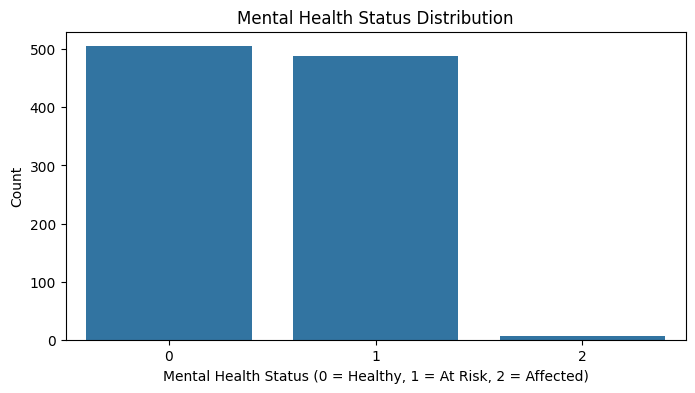

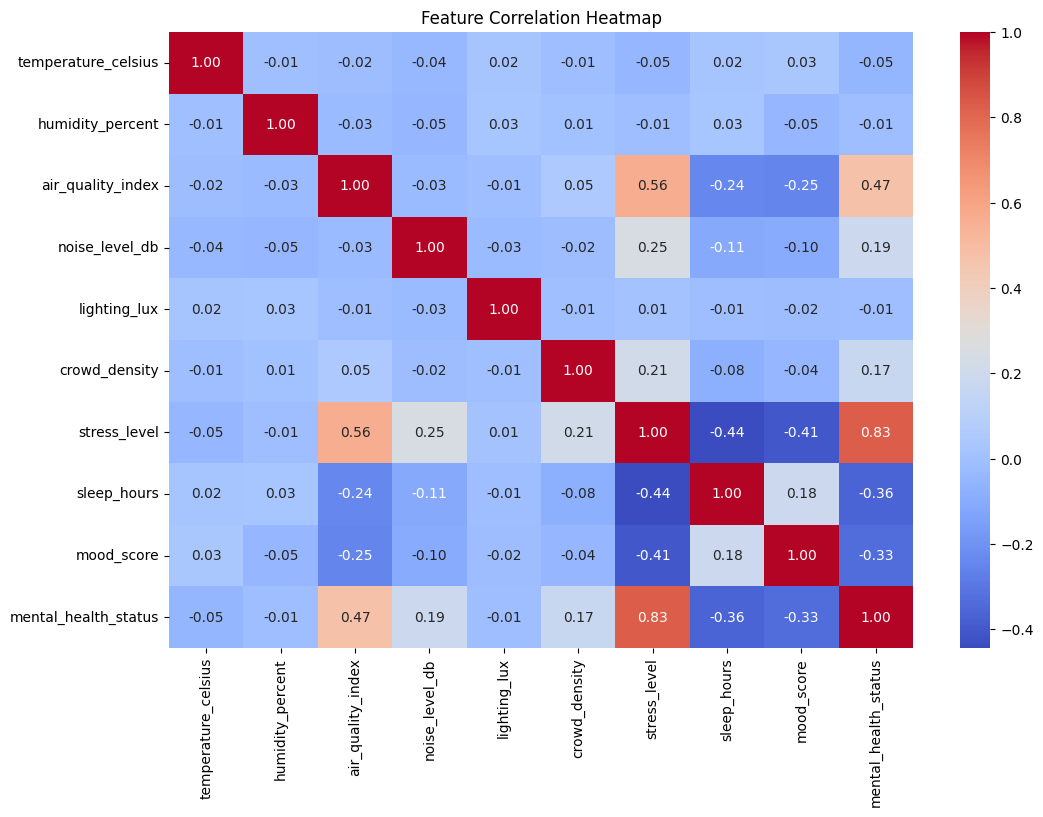

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of the target variable
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='mental_health_status')
plt.title("Mental Health Status Distribution")
plt.xlabel("Mental Health Status (0 = Healthy, 1 = At Risk, 2 = Affected)")
plt.ylabel("Count")
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.drop(['timestamp', 'location_id'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assume df is your DataFrame loaded previously

# Convert timestamp to datetime and extract hour
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# Drop unnecessary columns
df_model = df.drop(columns=['timestamp', 'location_id'])

# Features and target
X = df_model.drop(columns=['mental_health_status'])
y = df_model['mental_health_status']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model with class_weight='balanced'
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation with zero_division=0 to avoid warnings
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.995

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       0.99      1.00      0.99        98
           2       0.00      0.00      0.00         1

    accuracy                           0.99       200
   macro avg       0.66      0.67      0.66       200
weighted avg       0.99      0.99      0.99       200


Confusion Matrix:
 [[101   0   0]
 [  0  98   0]
 [  0   1   0]]


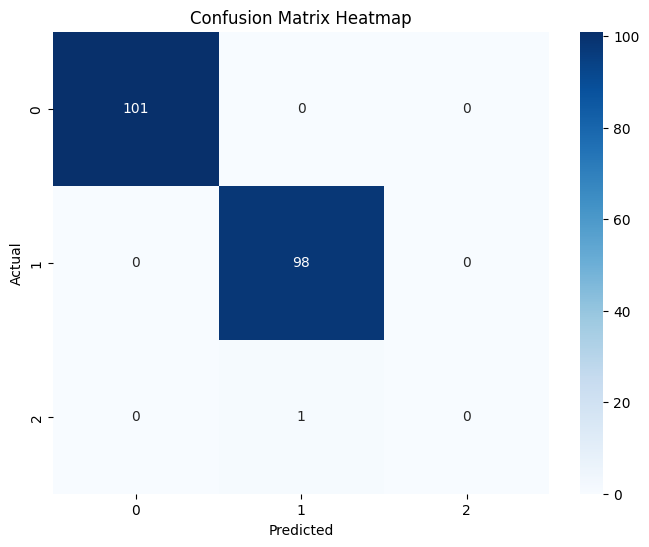

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


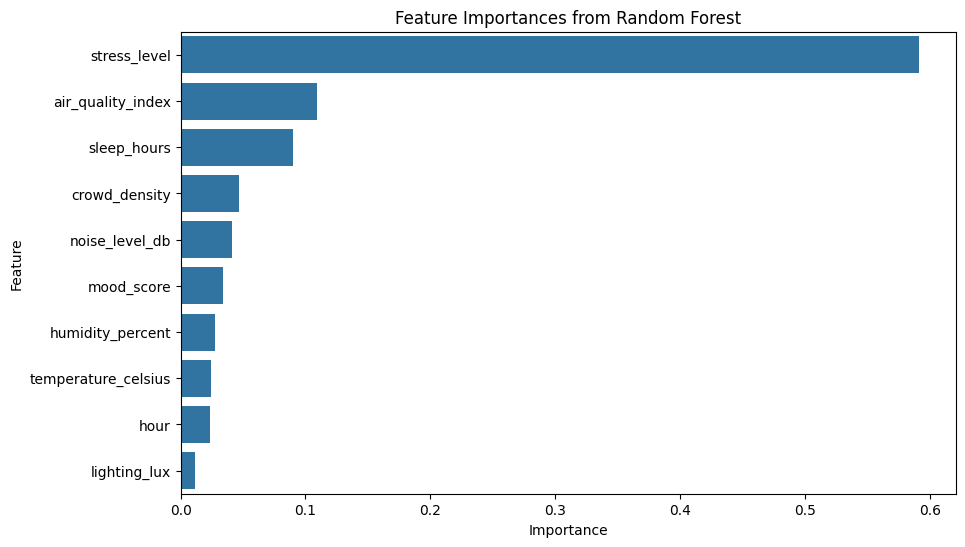

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X is a DataFrame before scaling
feature_names = X.columns

importances = model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances from Random Forest')
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use best estimator to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nClassification Report with Best Model:\n", classification_report(y_test, y_pred_best, zero_division=0))


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.9950062421972534

Classification Report with Best Model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       0.99      1.00      0.99        98
           2       0.00      0.00      0.00         1

    accuracy                           0.99       200
   macro avg       0.66      0.67      0.66       200
weighted avg       0.99      0.99      0.99       200



In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())


Cross-validation accuracy scores: [0.995 0.995 0.995 0.995 0.99 ]
Mean cross-validation accuracy: 0.994


In [16]:
import joblib

# Save model
joblib.dump(model, 'random_forest_model.pkl')

# Load model
loaded_model = joblib.load('random_forest_model.pkl')

# Predict with loaded model
y_pred_loaded = loaded_model.predict(X_test)
print("Accuracy with loaded model:", accuracy_score(y_test, y_pred_loaded))


Accuracy with loaded model: 0.995
